 # Sentiment analysis of football comments

 Code to plot sentiment timelines from match threads from reddit


 ## Setup

 To rerun, you need to set up praw (e.g. setting up client_id and client_secret).
 See [this tutorial](https://praw.readthedocs.io/en/stable/getting_started/quick_start.html) for more details.

 Then all the important details are placed in a json file in the directory where the code is run.

 ```json
 {
 "client_id": "",
 "client_secret": "",
 "password": "",
 "user_agent": "",

 ## Ready to run

 First import all packages needed.

In [1]:
#TODO UTC offset is going to be needed to be updated. Current uses British time
import praw
import datetime
import pandas as pd
import nltk.sentiment.vader
import matplotlib.pyplot as plt
import numpy as np
import os
import json
import requests
from copy import copy
from bs4 import BeautifulSoup

 ## Parameters

 This is the stuff that needs to be changed each game.


In [2]:
match_report_url = 'https://understat.com/match/16432'
# Path to match threads
rliverpoolfc_thread_id = 'pv9q4b' #/r/liverpoolfc
rsoccer_thread_id = 'pva1yf' #/r/soccer
# analysis name (year_competition_oponent_[h/a])
analysis_name = '2021_league_brentford_a'
# Kick off time
kickoff = datetime.time(17, 30)
second_half = datetime.time(18, 34)
halftime = 48 # match minutes in first half (for HT shading)


 ## Parameters (optional)

 This is the stuff that generally does not need to be changed, but can be if you want to change figure style or not use saved data.

In [3]:
# Define  NLTK object
vader = nltk.sentiment.vader.SentimentIntensityAnalyzer()
# set matplotlib style
plt.style.use('ggplot')
# Change this to 0 if you have downloaded the data and want to redownload
use_saved_data = 1


 ## The functions

 The code below are all functions used to download, parse and plot the data.

In [4]:
def get_match_report(match_report_url, kickoff, second_half, liverpool_home_away='h'):
    """
    Function gets all times and titles from match report from understat.

    Events are split between liverpool and opponent events.

    """
    # Open page and make a soup object
    resp = requests.get(match_report_url)
    soup = BeautifulSoup(resp.content)
    timeline = soup.find_all('div', {'class': 'timiline-container'})
    liverpool_event_title = []
    liverpool_event_time = []
    opponent_event_title = []
    opponent_event_time = []
    # Get the div class name depending on if team is home or away
    if liverpool_home_away == 'h':
        liverpool_div_class = 'block-home'
        opponent_div_class = 'block-away'
    else:
        liverpool_div_class = 'block-away'
        opponent_div_class = 'block-home'

    # Loops through all events in match report.
    for event in timeline:
        # Only take events where there is the correct side of understats page
        if event.find('div', {'class': liverpool_div_class}).text.replace('\n', '') != "":
            ev = event.find_all('i')
            timetmp = event.find('span', {'class': 'minute-value'}).text
            for e in ev:
                if e:
                    liverpool_event_title.append(e['title'])
                    liverpool_event_time.append(int(timetmp[:-1]))
        if event.find('div', {'class': opponent_div_class}).text.replace('\n', '') != "":
            ev = event.find_all('i')
            timetmp = event.find('span', {'class': 'minute-value'}).text
            for e in ev:
                if e:
                    opponent_event_title.append(e['title'])
                    opponent_event_time.append(int(timetmp[:-1]))

    # Times are returned in minutes-relative-to-kickoff time (i.e. the length of halftime needs to be added to all second half times)
    d = second_half - kickoff
    second_half_offset = d.seconds/60 - 45
    # Add the offset. 
    liverpool_event_time = np.array(liverpool_event_time)
    liverpool_event_time[liverpool_event_time >
                          45] = liverpool_event_time[liverpool_event_time > 45] + second_half_offset
    opponent_event_time = np.array(opponent_event_time)
    opponent_event_time[opponent_event_time >
                         45] = opponent_event_time[opponent_event_time > 45] + second_half_offset

    return liverpool_event_title, liverpool_event_time, opponent_event_title, opponent_event_time


def get_comments(thread_id, praw_info):
    """
    Gets top level comments from thread
    """
    reddit = praw.Reddit(client_id=praw_info['client_id'],
                         client_secret=praw_info['client_secret'],
                         password=praw_info['password'],
                         user_agent=praw_info['user_agent'],
                         username=praw_info['username'])
    submission = reddit.submission(id=thread_id)
    submission.comments.replace_more(limit=None, threshold=0)
    return submission


def split_comments_by_flair(submission):
    """
    splits comments by whether they have a Liverpool flair or not.
    For parsing /r/soccer comments
    """
    # create copys of input
    sub_l = copy(submission)
    sub_o = copy(submission)
    # create new comment output
    liverpool_comments = []
    other_comments = []
    for comment in submission.comments:
        if comment.author_flair_text == ':Liverpool:':
            liverpool_comments.append(comment)
        else:
            other_comments.append(comment)
    return liverpool_comments, other_comments

def comment_time_and_sentiment(comments):
    """
    From the comments, gets the time, the sentiment, and upvotes

    comments : praw submission.comments 

    returns a pandas dataframe of top comment time, sentiment, score and text
    """
    time = []
    sentiment = []
    score = []
    comment_list = []
    # Loop through top comments and add to time and sentiment list
    for top_level_comment in comments:
        comment = top_level_comment.body
        # remove any /n which may exist
        comment = comment.replace('\n', '')
        time.append((datetime.datetime.fromtimestamp(
            top_level_comment.created_utc) - datetime.timedelta(hours=1)))
        sentiment.append(vader.polarity_scores(comment)['compound'])
        score.append(top_level_comment.score)
        comment_list.append(comment)
    # Make time format
    pd_time = pd.to_datetime(time)
    # Make to dateframe
    df = pd.DataFrame(data={'sentiment': sentiment,
                            'score': score,
                            'comment': comment_list}, index=pd_time)
    return df


def posneg_sentiment_difference(df, bins='1min'):
    # Find comments with positive > 0 and negative < 0 sentiment
    pdf = df[df['sentiment'] > 0]
    ndf = df[df['sentiment'] < 0]

    # Bin
    pgdf = pdf.groupby(pd.Grouper(freq=bins)).count()
    ngdf = ndf.groupby(pd.Grouper(freq=bins)).count()
    diff_df = (pgdf['sentiment']-ngdf['sentiment']).dropna()
    return diff_df


def weighted_posneg_sentiment_difference(df, bins='1min'):
    # Find comments with positive > 0 and negative < 0 sentiment
    df = pd.DataFrame(df[df['score'] > 0])
    pdf = df[df['sentiment'] > 0]
    ndf = df[df['sentiment'] < 0]
    # Bin
    pgdf = pdf.groupby(pd.Grouper(freq=bins)).count()
    ngdf = ndf.groupby(pd.Grouper(freq=bins)).count()
    # Take the difference
    diff_df = (pgdf['sentiment']*pgdf['score'] -
               ngdf['sentiment']*ngdf['score']).dropna()
    return diff_df


def plot_sentiment_figure(time_rel_begin, df, ax, color='firebrick', label=None, width=2, mainfigure=None):
    # Main line
    ax.plot(time_rel_begin, df.values, linewidth=width, color=color, label=label)
    # Scale y axis (make even -/+ directions)
    if mainfigure:
        ax.set_ylim([-np.max(np.abs(ax.get_ylim())),
                    np.max(np.abs(ax.get_ylim()))])
        # Make axis ticks and labels correct
        ax.set_xlim([-30, 135])
        ax.set_xticks([0, 15, 30, 45, 60, 75, 90, 105])
        ax.set_xticklabels([0, 15, 30, 45, 45, 60, 75, 90])
        ax.set_xlabel('Time')
    return ax


def plot_match_events(ax, event, analysis_name):
    """
    Plots the match events.
    Sometimes needs to be tweaked per game
    """
    ax.scatter(event['liverpool_goal'], np.tile(1.15, len(event['liverpool_goal'])), color='black', s=30)
    ax.scatter(event['liverpool_redcard'], np.tile(0.85, len(event['liverpool_redcard'])),
                color='red', s=20, marker='s')
    ax.scatter(event['liverpool_yellowcard'], np.tile(0.85, len(event['liverpool_yellowcard'])), color='yellow', s=20, marker='s')
    ax.scatter(event['liverpool_substitute'], np.tile(0.85, len(event['liverpool_substitute'])),
                color='gray', s=20, marker=r'$\circlearrowleft$')
    for pen in event['liverpool_penalty']:
        ax.scatter(pen, 1.15, color='black', s=30)
        ax.text(pen, 1.15, 'P', fontsize='xx-small', color='white',
                horizontalalignment='center', verticalalignment='center')

    ax.scatter(event['opponent_goal'], np.tile(0.15, len(event['opponent_goal'])), color='black', s=30)
    ax.scatter(event['opponent_redcard'], np.tile(0.15, len(event['opponent_redcard'])),
                color='red', s=20, marker='s')
    ax.scatter(event['opponent_yellowcard'], np.tile(-0.15, len(event['opponent_yellowcard'])), color='yellow', s=20, marker='s')
    ax.scatter(event['opponent_substitute'], np.tile(-0.15, len(event['opponent_substitute'])),
                color='gray', s=20, marker=r'$\circlearrowleft$')
    for pen in event['opponent_penalty']:
        ax.scatter(pen, 0.15, color='black', s=30)
        ax.text(pen, 0.15, 'P', fontsize='xx-small', color='gray',
                horizontalalignment='center', verticalalignment='center')
    ax.set_yticks([0, 1])
    ax.set_yticklabels([analysis_name.split('_')[2].title(), 'Liverpool'])
    ax.set_ylim([-0.5, 1.5])

def get_rel_timevector(df, kickoff):
    """
    Converts the utc output to time vector relative to match timings
    """
    time_vector = list(df.index)
    time_rel_begin = []
    for t in time_vector:
        timetmp = datetime.datetime.combine(date, t.time())
        if timetmp >= kickoff:
            difference = timetmp - kickoff
            difference_mins = difference.seconds / 60
        else:
            difference = kickoff - timetmp
            difference_mins = -(difference.seconds / 60)
        time_rel_begin.append(difference_mins)
    return time_rel_begin

def add_filled_area_halftime(ax, kickoff, second_half):
    """
    Adds a fille region for halftime
    """
    # Get the second half start time relative to kickoff time in minutes
    second_half_start = second_half - kickoff
    second_half_start = second_half_start.seconds / 60
    scatter_y_min, scatter_y_max = ax.get_ylim()
    ax.fill_between([halftime, second_half_start-1], scatter_y_min, scatter_y_max +
                    np.abs(scatter_y_max*0.05), facecolor='dimgray', alpha=0.25, zorder=0)
    ax.text(halftime, scatter_y_min+np.abs(scatter_y_min*0.05),
            'Half time', fontsize='xx-small', color='gray')


def get_minmax_sentiment_comments(df):
    maxneg = df.iloc[df['sentiment'].argmin()]
    maxpos = df.iloc[df['sentiment'].argmax()]
    df_maxmin = pd.DataFrame(data=[maxneg, maxpos])
    return df_maxmin


 ## Download/load the data

 The next will load the data if available, otherwise try and download it

In [5]:
# If data doesn't exist, download it. If data exists, load it.
if use_saved_data == 1 and os.path.exists('./data/' + analysis_name + '_rliverpool.csv'):
    df_rliverpool = pd.read_csv('./data/' + analysis_name + '_rliverpool.csv',
                     index_col=0, parse_dates=[0])
    df_rsoccer_liverpool = pd.read_csv('./data/' + analysis_name + '_rsoccerliverpool.csv',
                     index_col=0, parse_dates=[0])
    df_rsoccer_other = pd.read_csv('./data/' + analysis_name + '_rsoccerother.csv',
                     index_col=0, parse_dates=[0])
else:
    # read in reddit api info
    with open('praw.json') as f:
        praw_info = json.load(f)
    # do the sentiment analysis
    submission = get_comments(rliverpoolfc_thread_id, praw_info)
    df_rliverpool = comment_time_and_sentiment(submission.comments)
    df_rliverpool.to_csv('./data/' + analysis_name + '_rliverpool.csv')
    # author_flair_text
    submission = get_comments(rsoccer_thread_id, praw_info)
    comments_rsoccer_liverpool, comments_rsoccer_other = split_comments_by_flair(submission)
    df_rsoccer_liverpool = comment_time_and_sentiment(comments_rsoccer_liverpool)
    df_rsoccer_liverpool.to_csv('./data/' + analysis_name + '_rsoccerliverpool.csv')
    df_rsoccer_other = comment_time_and_sentiment(comments_rsoccer_other)
    df_rsoccer_other.to_csv('./data/' + analysis_name + '_rsoccerother.csv')
    # Delete reddit api info
    praw_info = {}


 ## Get match report and parse events

 This is the cell that should be improved.

 First the data is got from the match reports.
 Then it is parsed into different events.
 If manually entering the data, then lists can be provided to the event['event'] dictionary key.

In [6]:
# Get the kickoff and second half start times
date = datetime.date(1, 1, 1)
kickoff = datetime.datetime.combine(date, kickoff)
second_half = datetime.datetime.combine(date, second_half)
liverpool_events, liverpool_timings, opponent_events, opponent_timings = get_match_report(match_report_url, kickoff, second_half, analysis_name.split('_')[-1])

# Parse events. These can be manual in other divisions
event = {}
event['liverpool_goal'] = [liverpool_timings[i] for i, t in enumerate(liverpool_events) if t == 'Goal']
event['liverpool_penalty'] = [liverpool_timings[i] for i, t in enumerate(liverpool_events) if t == 'Penalty']
event['liverpool_substitute'] = [liverpool_timings[i]
              for i, t in enumerate(liverpool_events) if t == 'Substitution']
event['liverpool_redcard'] = [liverpool_timings[i] for i, t in enumerate(liverpool_events) if t == 'Red card']
event['liverpool_yellowcard'] = [liverpool_timings[i]
              for i, t in enumerate(liverpool_events) if t == 'Yellow card']

event['opponent_goal'] = [opponent_timings[i] for i, t in enumerate(opponent_events) if t == 'Goal']
event['opponent_penalty'] = [opponent_timings[i] for i, t in enumerate(opponent_events) if t == 'Penalty']
event['opponent_substitute'] = [opponent_timings[i]
              for i, t in enumerate(opponent_events) if t == 'Substitution']
event['opponent_redcard'] = [opponent_timings[i] for i, t in enumerate(opponent_events) if t == 'Red card']
event['opponent_yellowcard'] = [opponent_timings[i]
              for i, t in enumerate(opponent_events) if t == 'Yellow card']


 ## Mark summary measures of each sentiment dataframe

 Here we used the loaded data and calculate the different metrics used.
 The first is the number of positive comments - the number of negative comments.
 The second weights the comments by the score (i.e) number of upvotes.

In [7]:
posneg_df_rliverpool = posneg_sentiment_difference(df_rliverpool, bins='2min')
weighted_posneg_df_rliverpool = weighted_posneg_sentiment_difference(df_rliverpool, bins='1min')
posneg_df_rsoccer_liverpool = posneg_sentiment_difference(df_rsoccer_liverpool, bins='2min')
weighted_posneg_df_rsoccer_liverpool = weighted_posneg_sentiment_difference(df_rsoccer_liverpool, bins='1min')
posneg_df_rsoccer_other = posneg_sentiment_difference(df_rsoccer_other, bins='2min')
weighted_posneg_df_rsoccer_other = weighted_posneg_sentiment_difference(df_rsoccer_other, bins='1min')
df_maxmin = get_minmax_sentiment_comments(df_rliverpool)


 ## Time to create the plot

 Now that all data is plotted, the plots can be created.

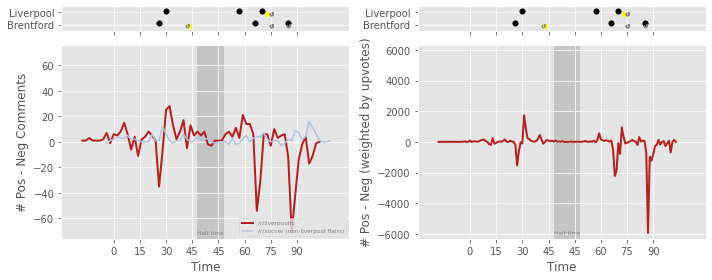

In [8]:
# Create a 2x2 figure grid
fig, ax = plt.subplots(2, 2, gridspec_kw={'height_ratios': [1, 8]}, sharex=True, figsize=(10, 4))
ax = ax.flatten()

# Plot match events in top row
plot_match_events(ax[0], event, analysis_name)
plot_match_events(ax[1], event, analysis_name)

# Plot sentiment
reltime_rliverpoolfc = get_rel_timevector(posneg_df_rliverpool, kickoff)
ax[2] = plot_sentiment_figure(reltime_rliverpoolfc, posneg_df_rliverpool, ax[2], 'firebrick', '/r/liverpoolfc', mainfigure=True)
#ax[2] = plot_sentiment_figure(get_rel_timevector(posneg_df_rsoccer_liverpool, kickoff), posneg_df_rsoccer_liverpool, ax[2], 'lightcoral', '/r/soccer (liverpool flair)', 1.5)
ax[2] = plot_sentiment_figure(get_rel_timevector(posneg_df_rsoccer_other, kickoff), posneg_df_rsoccer_other, ax[2], 'lightsteelblue', '/r/soccer (non-liverpool flairs)', 1.5)
ax[2].set_ylabel('# Pos - Neg Comments')
add_filled_area_halftime(ax[2], kickoff, second_half)

# Add points for the most positive and most negative comments
#reltime_minmax = get_rel_timevector(df_maxmin, kickoff)
# Get the index relative to the sentiment line
# neg_idx = (np.abs(np.array(reltime_rliverpoolfc) - reltime_minmax[0])).argmin()
# pos_idx = (np.abs(np.array(reltime_rliverpoolfc) - reltime_minmax[1])).argmin()
# ax[2].scatter(reltime_rliverpoolfc[pos_idx], posneg_df_rliverpool[pos_idx], color='darkgreen', s=10, label='most positive comment', zorder=1000)
# ax[2].scatter(reltime_rliverpoolfc[neg_idx], posneg_df_rliverpool[neg_idx], color='darkgray', s=10, label='most negative comment', zorder=1000)
# # print the min/max comments
# print('Most negative comment:')
# print(df_maxmin.iloc[0]['comment'])
# print('Most positive comment:')
# print(df_maxmin.iloc[1]['comment'])

# Add legend
ax[2].legend(loc='lower right', fontsize='xx-small', labelcolor='gray')

# Plot weighted figure
ax[3] = plot_sentiment_figure(get_rel_timevector(weighted_posneg_df_rliverpool, kickoff), weighted_posneg_df_rliverpool, ax[3], 'firebrick', '/r/liverpoolfc', mainfigure=True)
#ax[3] = plot_sentiment_figure(get_rel_timevector(weighted_posneg_df_rsoccer, kickoff), weighted_posneg_df_rsoccer, ax[3], 'lightsteelblue', '/r/soccer')
ax[3].set_ylabel('# Pos - Neg (weighted by upvotes)')
add_filled_area_halftime(ax[3], kickoff, second_half)

# Save
fig.tight_layout()
fig.savefig('./figures/' + analysis_name + '.png', dpi=300)
fig.savefig('./figures/' + analysis_name + '.pdf', dpi=300)

